# Импорт библиотек

Поскольку *lightfm* работает не корректно в windows, выполним проверку среды выполнения (локально или в Google Colab).

In [1]:
# Проверяем, выполняется ли код в Google Colab
try:
    import google.colab
    IN_COLAB = True
except:
    IN_COLAB = False

# Устанавливаем путь в зависимости от среды выполнения
if IN_COLAB:
    from google.colab import drive
    drive.mount('/content/drive/')

    # Определим пути для Colab
    DATA_PATH    = '/content/drive/MyDrive/DS/IDE/unit_tasks/Трек ML-инженер/Дипломный проект/data/'
    MODEL_PATH   = '/content/drive/MyDrive/DS/IDE/unit_tasks/Трек ML-инженер/Дипломный проект/models/'
    SCRIPTS_PATH = '/content/drive/MyDrive/DS/IDE/unit_tasks/Трек ML-инженер/Дипломный проект/scripts/'

    import sys
    sys.path.append(SCRIPTS_PATH)

    !pip install -q implicit
    !pip install -q category_encoders
    !pip install -q memory_profiler
    !pip install -q lightfm

    location = 'Запущено в Google Colab'

else:
    # Определим пути для локального расположения
    DATA_PATH    = '../data/'
    MODEL_PATH   = '../models/'
    SCRIPTS_PATH = '../scripts/'

    import sys
    sys.path.append(SCRIPTS_PATH)

    location = 'Запущено локально'

print(location)

Mounted at /content/drive/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.9/8.9 MB 54.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.9/81.9 kB 2.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 316.4/316.4 kB 6.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
Запущено в Google Colab


In [2]:
import os
import gc
import sys
import pickle
import random
import holidays
import threadpoolctl
import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt

import scipy
import scipy.sparse as sparse
from scipy.sparse import csr_matrix
from scipy.sparse import coo_matrix
from scipy.cluster.hierarchy import dendrogram, linkage

from lightfm import LightFM
from lightfm.evaluation import precision_at_k, recall_at_k
from lightfm.cross_validation import random_train_test_split

from implicit.als import AlternatingLeastSquares
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report

import category_encoders as ce
import xgboost as xgb

os.environ['OPENBLAS_NUM_THREADS'] = '1'

threadpoolctl.threadpool_limits(1, "blas")

%load_ext memory_profiler

from data_preprocessing import date_conversion
from data_preprocessing import get_memory_usage
from data_preprocessing import optimize_numeric_columns
from data_preprocessing import ilif
from data_preprocessing import create_dataframe

# Знакомство с данными

## Постановка задачи

**Бизнес-постановка задачи:**  
Разработать рекомендательную систему, с целью повысить прибыль от допродаж в интернет-магазине, на 20 %

**Техническая задача:**  
Разместить на главной странице сайта рекомендации товаров по идентификатору пользователя в трех местах.

* Создать сервис, выдающий рекомендации по идентификатору пользователя.
* Обёрнуть сервис в Docker.
* Написать документацию, описание функциональности.
* Сделать презентацию для менеджера с описанием принципов работы.

**Техническая метрика оценки качества:**  
Precision@3

## Характеристики данных

**events** — датасет с событиями. Колонки:
* timestamp — время события
* visitorid — идентификатор пользователя
* event — тип события
* itemid — идентификатор объекта
* transactionid — идентификатор транзакции, если она проходила

**category_tree** — файл с деревом категорий (можно восстановить дерево).
* category_id — идентификатор категорий
* parent_id — идентификатор родительской категории

**item_properties** — файл с свойствами товаров.
* timestamp — момент записи значения свойства
* item_id — идентификатор объекта
* property — свойство, кажется, они все, кроме категории, захешированы
* value — значение свойства

**Ссылки на:**  
* [Файлы данных](https://drive.google.com/file/d/1nAQErFnOAAwkg3kQzoQ8r7nq_ztbTfVN/view?usp=sharing)  
* [Модели](https://drive.google.com/file/d/1nBTsTrer0sIsVwz1QSxCH9je5n_JG2zy/view?usp=sharing)

## Загрузка данных

In [3]:
events          = pd.read_csv(DATA_PATH + 'events.csv')
category_tree   = pd.read_csv(DATA_PATH + 'category_tree.csv')
item_properties = pd.concat([
    pd.read_csv(DATA_PATH + 'item_properties_part1.csv'),
    pd.read_csv(DATA_PATH + 'item_properties_part2.csv')
])

In [4]:
events          = events.sample(10000).copy().reset_index()
item_properties = item_properties.sample(10000).copy().reset_index()

In [5]:
display(events.head(3))
display(category_tree.head(3))
display(item_properties.head(3))

,index,timestamp,visitorid,event,itemid,transactionid
0,2310558,1436721675878,1243298,addtocart,444991,NaN
1,1296222,1441758415199,1062593,view,171632,NaN
2,1602208,1431243009329,1376913,view,369933,NaN


,categoryid,parentid
0,1016,213.0
1,809,169.0
2,570,9.0


,index,timestamp,itemid,property,value
0,1453356,1432436400000,254995,790,n29088.000
1,4095057,1433041200000,217557,364,1113896
2,8853720,1434250800000,9104,283,260449 150169 725792 31884 686540 641987 36768...


# Исследование данных

## Описание структуры данных

In [6]:
print(f'events: {events.shape}')
print(f'category_tree: {category_tree.shape}')
print(f'item_properties: {item_properties.shape}')

events: (10000, 6)
category_tree: (1669, 2)
item_properties: (10000, 5)


Наборы данных с событиями и свойствами товаров достаточно большие (имеют почти 3 и 20 млн. записей соответсвенно). Посмотрим на строковые признаки, какое количество уникальных значений они содержат.

In [7]:
print(f'Типы событий: {events["event"].unique()}')
print(f'Количество уникальных признаков товара: {item_properties["property"].nunique()}')

Типы событий: ['addtocart' 'view' 'transaction']
Количество уникальных признаков товара: 500


Поскольку разных типов всего три и уникальных признаков товара всего около 1000 из 20 млн., приведем эти признаки к категориальному типу, для экономии оперативной памяти и небольшого ускорения обработки данных.

За одно, приведем числовые признаки к наименьшей разрядности int и float.

## Оптимизация данных

Подсчет занимаемой оперативной памяти

In [8]:
events_before           = get_memory_usage(events)
category_tree_before    = get_memory_usage(category_tree)
item_properties_before  = get_memory_usage(item_properties)

print('Объем занимаемой помяти до оптимизации:')
print(f'events\t\t{events_before} Mb')
print(f'category_tree\t{category_tree_before} Mb')
print(f'item_properties {item_properties_before} Mb')

Объем занимаемой помяти до оптимизации:
events		1.0 Mb
category_tree	0.0 Mb
item_properties 1.5 Mb


Преобразование даты

In [9]:
events          = date_conversion(events, 'timestamp')
item_properties = date_conversion(item_properties, 'timestamp')

Преобразование типов данных, для уменьшения используемой памяти.

In [10]:
events['event'] = events['event'].astype('category')

item_properties['property'] = item_properties['property'].astype('category')

In [11]:
events          = optimize_numeric_columns(events)
item_properties = optimize_numeric_columns(item_properties)

Повторный подсчет занимаемой оперативной памяти

In [12]:
events_after           = get_memory_usage(events)
item_properties_after  = get_memory_usage(item_properties)

events_percent          = (events_after / events_before) * 100
item_properties_percent = (item_properties_after / item_properties_before) * 100

print('Объем занимаемой помяти после оптимизации:')
print(f'events\t\t{events_after} Mb \t(уменьшено на {100 - events_percent.round(1)} %)')
print(f'item_properties {item_properties_after} Mb \t(уменьшено на {100 - item_properties_percent.round(1)} %)')

Объем занимаемой помяти после оптимизации:
events		0.2 Mb 	(уменьшено на 80.0 %)
item_properties 0.9 Mb 	(уменьшено на 40.0 %)


## Статистический анализ данных

Посмотрим на временной период данных

In [13]:
print(f'Начальная дата: {events["date"].min()}')

print(f'Конечная дата: {events["date"].max()}')

Начальная дата: 2015-05-03 03:06:27.262000
Конечная дата: 2015-09-18 01:48:08.255000


Посмотрим, какой процент продаж обеспечивают топовые товары после 1 июля

In [14]:
before_july = events[(events['date'] <= '2015-07-01') & (events['event'] == 'transaction')]
after_july  = events[(events['date'] > '2015-07-01')  & (events['event'] == 'transaction')]

# Найдите топ-3 товара до 1 июля по числу транзакций
top_items_before_july = before_july['itemid'].value_counts().head(3)

# Выделите транзакции с товарами из топ-3 после 1 июля
transactions_after_july = after_july[after_july['itemid'].isin(top_items_before_july.index)]

# Посчитайте процент продаж, которые обеспечивают эти топ-3 товара после 1 июля
percentage_sales_covered = transactions_after_july.shape[0] / after_july.shape[0] * 100

print(f"Процент продаж, обеспечиваемых топ-3 товарами после 1 июля: {percentage_sales_covered:.2f}%")

Процент продаж, обеспечиваемых топ-3 товарами после 1 июля: 0.00%


In [15]:
events.describe().round(2)

,index,visitorid,itemid,transactionid
count,10000.00,10000.00,10000.00,95.00
mean,1374246.54,700347.60,234010.48,8892.85
std,794305.10,405097.20,133929.16,5225.96
min,21.00,100.00,190.00,63.00
25%,685174.00,347309.00,116671.25,4660.50
50%,1378954.50,705172.00,234445.00,8568.00
75%,2061660.25,1049444.25,350027.25,13209.50
max,2755817.00,1407558.00,466736.00,17594.00


В признаке **transaction** всего 22457 записей, проверим количество успешных транзакций

In [16]:
print(f'Количество выполенных транзакций: {events[events["event"] == "transaction"].shape[0]}')

Количество выполенных транзакций: 95


### Посмотрим на процент пропусков

In [17]:
round((events.isna().sum() / events.shape[0]) * 100, 2)

index             0.00
visitorid         0.00
event             0.00
itemid            0.00
transactionid    99.05
date              0.00
dtype: float64

In [18]:
round((item_properties.isna().sum() / item_properties.shape[0]) * 100, 2)

index       0.0
itemid      0.0
property    0.0
value       0.0
date        0.0
dtype: float64

### Распределение типов событий

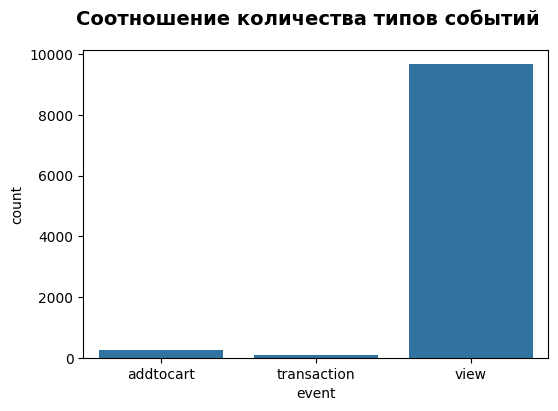

In [19]:
plt.figure(figsize=(6, 4))
event_countplot = sns.countplot(
    data=events,
    x='event')
plt.suptitle(
    'Соотношение количества типов событий',
    fontweight='bold',
    fontsize=14);

Признак transactionid содержит 99 % пропусков, это обусловлено тем, что количество выполненных транзакций равно 22457 из 2756101 записей. Подавляющее большинство записей являются только просмотром товара.

### Распределение признаков

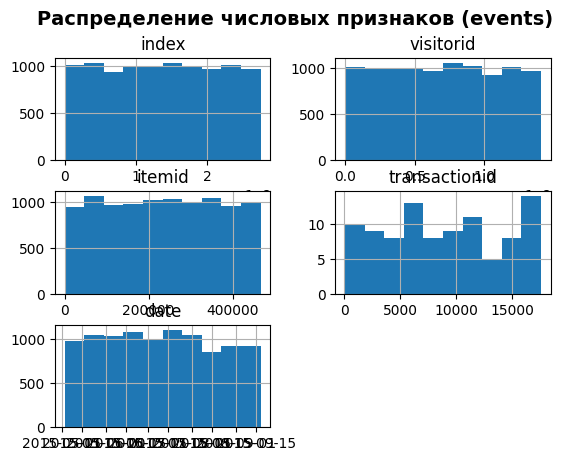

In [20]:
event_hist = events.hist();
plt.suptitle(
    'Распределение числовых признаков (events)',
    fontweight='bold',
    fontsize=14);

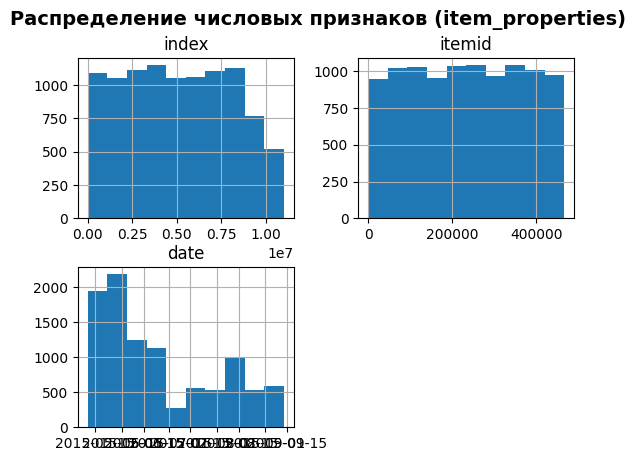

In [21]:
item_properties.hist()
plt.suptitle(
    'Распределение числовых признаков (item_properties)',
    fontweight='bold',
    fontsize=14);

### Проверим корреляцию

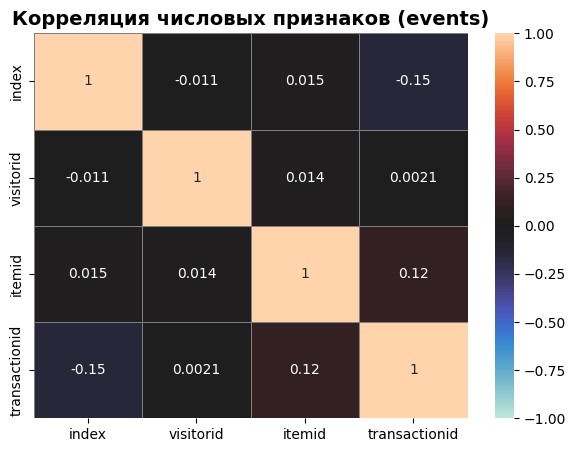

In [22]:
corr = events[events.describe().columns].corr().round(4)

plt.subplots(figsize=(7,5))
heatmap = sns.heatmap(
    corr,
    annot      = True,
    linewidths = 0.5,
    vmin       = -1,
    vmax       = 1,
    center     = 0,
    linecolor  = 'grey')
heatmap.set_title('Корреляция числовых признаков (events)', fontweight='bold', size=14);

Данные имют нулевую корреляцию и никак не связаны между собой

### Поиск дубликатов

In [23]:
dupl_columns = list(events.columns)

mask = events.duplicated(subset=dupl_columns)
print(f'Число найденных дубликатов в events: {events[mask].shape[0]}')

# удалим дубликаты
events = events.drop_duplicates(keep='first')

Число найденных дубликатов в events: 0


In [24]:
dupl_columns = list(item_properties.columns)

mask = item_properties.duplicated(subset=dupl_columns)
item_properties_duplicates = item_properties[mask]
print(f'Число найденных дубликатов в item_properties: {item_properties_duplicates.shape[0]}')

Число найденных дубликатов в item_properties: 0


### Определение неинформативных признаков

In [25]:
ilif(events)

index: 100.0% уникальных значений
visitorid: 95.73% уникальных значений
event: 96.64% одинаковых значений
transactionid: 100.0% уникальных значений
date: 100.0% уникальных значений


In [26]:
ilif(item_properties)

index: 99.96% уникальных значений
itemid: 98.58% уникальных значений


В целом можно сделать вывод, что неинформативных признаков в датасете нет.

### Дерево категорий

Посмотрим на визуализацию дерева категорий

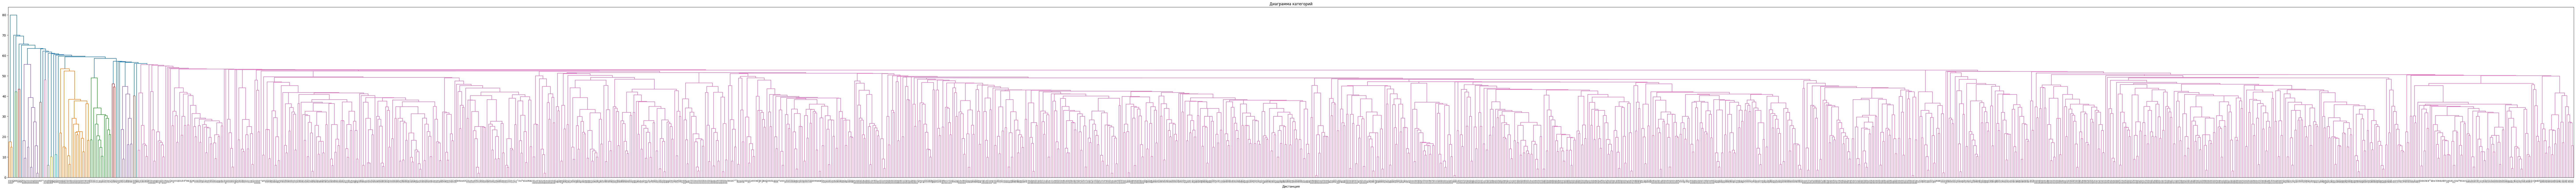

In [27]:
# Заполняем NaN значениями, чтобы избежать ошибок при построении дендрограммы
ct = category_tree.fillna(0)

# Создаем матрицу связей для построения дендрограммы
links = linkage(ct[['categoryid', 'parentid']], 'single')

# Строим дендрограмму
plt.figure(figsize=(150, 10))
dendrogram(
    links,
    labels=ct['categoryid'].tolist(),
    orientation='top',
    leaf_font_size=5
)
plt.title('Диаграмма категорий')
plt.xlabel('Дистанция')
plt.show();

Как видно из графика, товары имеют обширную и достатоно подробную группировку по категориям.

### Самые популярные item-ы

Посмотрим на топ 50 самых популярных товаров, котрые просматривали, доавили в корзину и выполнили транзакцию.

In [28]:
# Разделим датасет по типу событий
events_view         = events[events['event'] == 'view']
events_addtocart    = events[events['event'] == 'addtocart']
events_transaction  = events[events['event'] == 'transaction']

In [29]:
# Рассчитаем количество событий для каждого айтема
item_popularity_view        = events_view.groupby('itemid')['event'].count().reset_index().rename(columns={'event': 'popularity_view'})
item_popularity_addtocart   = events_addtocart.groupby('itemid')['event'].count().reset_index().rename(columns={'event': 'popularity_addtocart'})
item_popularity_transaction = events_transaction.groupby('itemid')['event'].count().reset_index().rename(columns={'event': 'popularity_transaction'})

In [30]:
# Возьмем топ 50 популярных транзакций
df_view         = item_popularity_view.sort_values(by='popularity_view', ascending=False).head(50)
df_addtocart    = item_popularity_addtocart.sort_values(by='popularity_addtocart', ascending=False).head(50)
df_transaction  = item_popularity_transaction.sort_values(by='popularity_transaction', ascending=False).head(50)

In [31]:
# Объединение данных по столбцу itemid, оставив только те события, который имеют все три события
merged_df = pd.merge(df_view, df_addtocart, on='itemid')
# Добавим процент добавленных в корзину, по отношению к просмотрам
merged_df['popularity_addtocart_%'] = round((merged_df['popularity_addtocart'] / merged_df['popularity_view']) * 100, 2)

merged_df = pd.merge(merged_df, df_transaction, on='itemid')
# Добавим процент выполненных транзакций, по отношению к добавленным в корзину
merged_df['popularity_transaction_%'] = round((merged_df['popularity_transaction'] / merged_df['popularity_addtocart']) * 100, 2)

merged_df

,itemid,popularity_view,popularity_addtocart,popularity_addtocart_%,popularity_transaction,popularity_transaction_%


Можно сделать вывод, что товар с id **461686** является достаточно популярным, его больше всего просматривают, с 12% верятностью добавляют в корзину и после этого с 44% шансом совершают транзакцию.

Так же интересны товары с id **312728** и **445351**

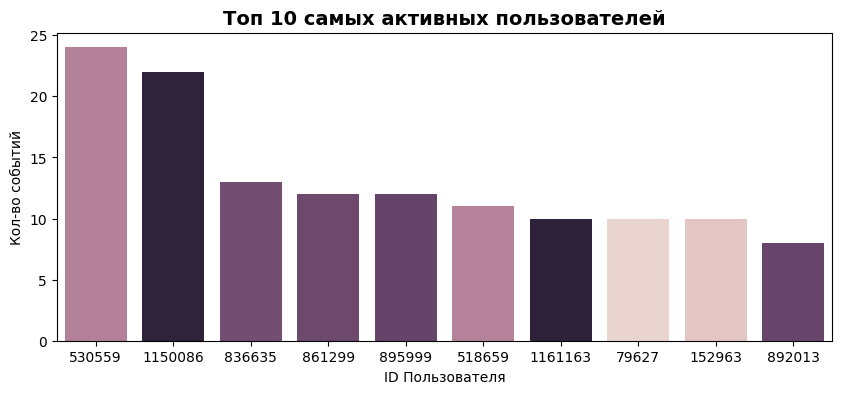

In [32]:
top_most_active_user = events['visitorid'].value_counts().head(10)
top_most_active_user = top_most_active_user.sort_values(ascending=False)

plt.figure(figsize=(10, 4))

sns.barplot(
    x     = top_most_active_user.index,
    y     = top_most_active_user.values,
    order = top_most_active_user.index,
    hue   = top_most_active_user.index,
    legend = False
)
plt.title('Топ 10 самых активных пользователей', fontweight='bold', fontsize=14)
plt.xlabel('ID Пользователя')
plt.ylabel('Кол-во событий')
plt.show();

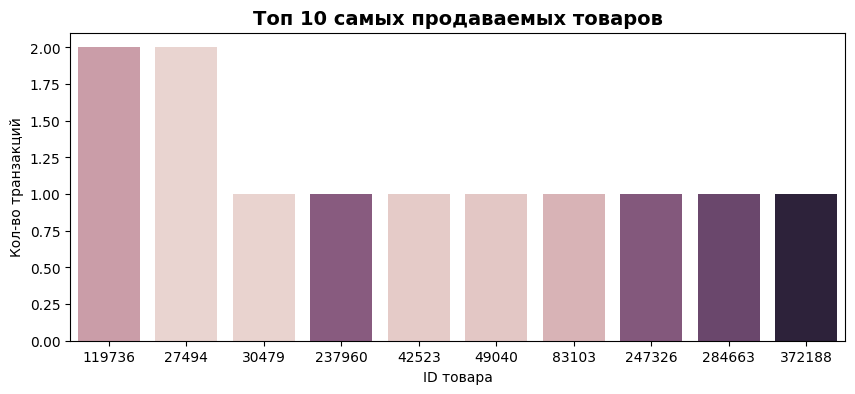

In [33]:
top_sold_items = events[events['event']=='transaction']['itemid'].value_counts().head(10)
top_sold_items = top_sold_items.sort_values(ascending=False)

plt.figure(figsize=(10, 4))
sns.barplot(
    x      = top_sold_items.index,
    y      = top_sold_items.values,
    order  = top_sold_items.index,
    hue    = top_sold_items.index,
    legend = False
)
plt.title('Топ 10 самых продаваемых товаров', fontweight='bold', fontsize=14)
plt.xlabel('ID товара')
plt.ylabel('Кол-во транзакций')
plt.show();

# Создание факторов для модели

## Генерация факторов, связанных с датой

In [34]:
# Извлеките признаки
events['hour']          = events['date'].dt.hour
events['month']         = events['date'].dt.month
events['day_of_week']   = events['date'].dt.dayofweek
events['is_weekend']    = events['date'].dt.weekday // 5  # 1 - выходной, 0 - будний день

# Определите праздничные дни
us_holidays = holidays.US(years=events['date'].dt.year.unique())
events['is_holiday'] = events['date'].dt.date.apply(lambda x: 1 if x in us_holidays else 0)

# Определите временной признак
events['time_of_day'] = pd.cut(events['date'].dt.hour,
                           bins=[0, 6, 12, 18, 24],
                           labels=['Night', 'Morning', 'Afternoon', 'Evening'],
                           include_lowest=True)

# Выведите результат
events.head(3)

,index,visitorid,event,itemid,transactionid,date,hour,month,day_of_week,is_weekend,is_holiday,time_of_day
0,2310558,1243298,addtocart,444991,NaN,2015-07-12 17:21:15.878,17,7,6,1,0,Afternoon
1,1296222,1062593,view,171632,NaN,2015-09-09 00:26:55.199,0,9,2,0,0,Night
2,1602208,1376913,view,369933,NaN,2015-05-10 07:30:09.329,7,5,6,1,0,Morning


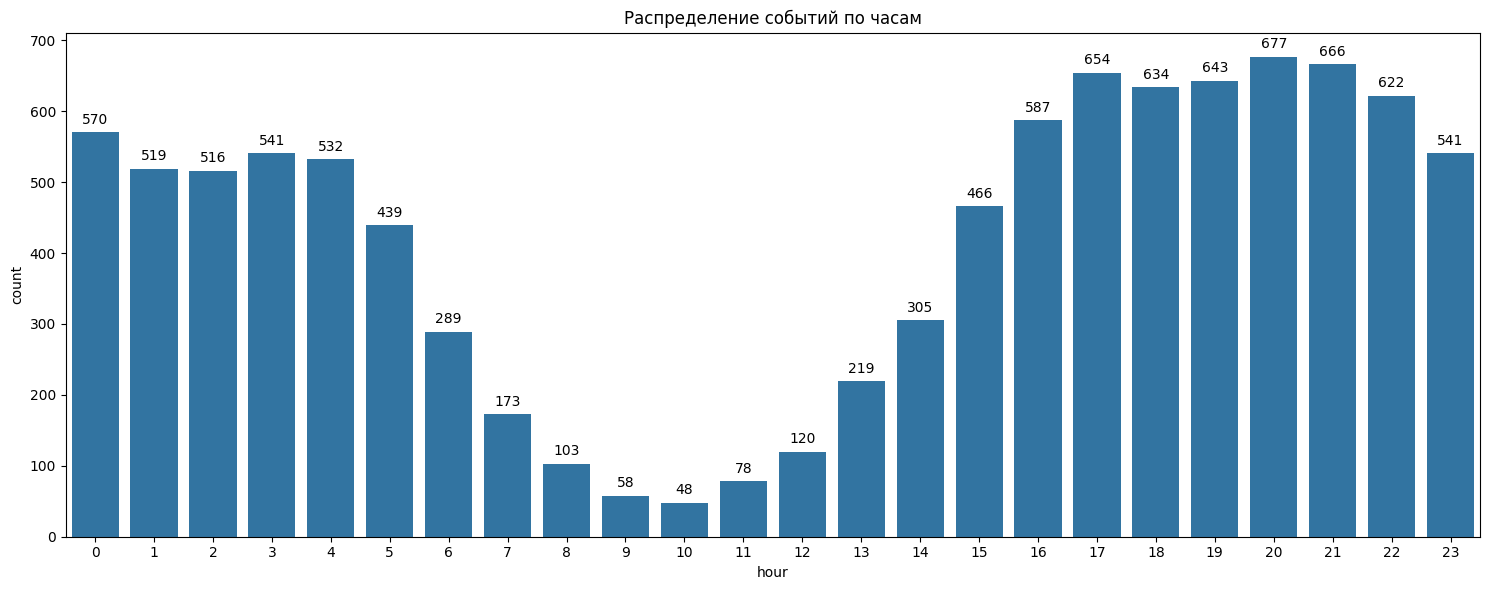

In [35]:
plt.figure(figsize=(15, 6))

countplot = sns.countplot(data=events, x='hour')
plt.title('Распределение событий по часам')
for p in countplot.patches:
    countplot.annotate(
        format(p.get_height(), '.0f'),
        (p.get_x() + p.get_width() / 2., p.get_height()),
        ha = 'center',
        va = 'center',
        xytext = (0, 9),
        textcoords = 'offset points'
    )

plt.tight_layout()
plt.show();

In [36]:
# Создаем дамми-переменные (One-Hot Encoding)
one_hot_encoded = pd.get_dummies(events['time_of_day'], prefix='time_of_day_')

# Добавляем полученные дамми-переменные к исходному DataFrame
events = pd.concat([events, one_hot_encoded], axis=1)

# Удаляем исходный столбец 'time_of_day', так как он больше не нужен
events = events.drop('time_of_day', axis=1)

# Выводим полученный DataFrame
events.head(3)

,index,visitorid,event,itemid,transactionid,date,hour,month,day_of_week,is_weekend,is_holiday,time_of_day__Night,time_of_day__Morning,time_of_day__Afternoon,time_of_day__Evening
0,2310558,1243298,addtocart,444991,NaN,2015-07-12 17:21:15.878,17,7,6,1,0,0,0,1,0
1,1296222,1062593,view,171632,NaN,2015-09-09 00:26:55.199,0,9,2,0,0,1,0,0,0
2,1602208,1376913,view,369933,NaN,2015-05-10 07:30:09.329,7,5,6,1,0,0,1,0,0


## Генерация факторов, связанных с айтемами

In [37]:
# Сделаем копию данных
f_events    = events.copy()
xgb_events  = events.copy()

In [38]:
mapping = {'view': 0, 'transaction': 1, 'addtocart': 1}
events['event'] = np.vectorize(mapping.get)(events['event'])

Генерация факторов, связанных с айтемами, используя матричную факторизацию с алгоритмом ALS

In [40]:
# Имена файлов
events_item_user = 'events_item_user.csv'

# Полные пути к файлам
events_item_user_filepath = os.path.join(DATA_PATH, events_item_user)

# Проверка наличия файлов
if os.path.exists(events_item_user_filepath):
    # Загрузка данных
    events = pd.read_csv(events_item_user_filepath)

    print('Данные успешно загружены.')

    display(events.head(3))
else:
    # Создание разреженной матрицы item-user
    events['event_value'] = (events['event'] == 1).astype(int)
    item_user_matrix = coo_matrix((events['event_value'], (events['itemid'], events['visitorid']))).tocsr()

    # Инициализация ALS модели
    als_model = AlternatingLeastSquares(factors=20, regularization=0.1, iterations=50)

    # Обучение модели ALS
    als_model.fit(item_user_matrix)

    # Получение факторов для айтемов
    item_factors = als_model.item_factors

    # Создание DataFrame с факторами айтемов
    item_factors_df = pd.DataFrame(item_factors, index=range(1, item_factors.shape[0] + 1), columns=[f'item_factor_{i}' for i in range(item_factors.shape[1])])

    # Добавление факторов айтемов к исходному датасету с айтемами
    # items_with_factors = pd.merge(events, item_factors_df, left_on='itemid', right_index=True, how='left')
    events = pd.merge(events, item_factors_df, left_on='itemid', right_index=True, how='left')

    events.to_csv(DATA_PATH + "events_item_user.csv", index=False)

    display(events.head(3))

Данные успешно загружены.


,index,visitorid,event,itemid,transactionid,date,hour,month,day_of_week,is_weekend,...,item_factor_10,item_factor_11,item_factor_12,item_factor_13,item_factor_14,item_factor_15,item_factor_16,item_factor_17,item_factor_18,item_factor_19
0,1107312,462697,1,382177,NaN,2015-08-28 15:22:15.384,15,8,4,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2643823,846990,0,197901,NaN,2015-07-26 17:39:42.718,17,7,6,1,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,861190,381058,0,123964,NaN,2015-08-14 19:50:53.946,19,8,4,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## Генерация факторов юзер-айтем

Создание факторов для айтемов и пользователей с использованием ALS. Мы будем использовать разреженную матрицу user-item, транспонированную относительно предыдущей матрицы.

In [41]:
# Имена файлов
events_user_item = 'events_user_item.csv'

# Полные пути к файлам
events_user_item_filepath = os.path.join(DATA_PATH, events_user_item)

# Проверка наличия файлов
if os.path.exists(events_user_item_filepath):
    # Загрузка данных
    events = pd.read_csv(events_user_item_filepath)

    print('Данные успешно загружены.')

    # Выполним оптимизацию загруженного датасета
    events_before           = get_memory_usage(events)
    print('Объем занимаемой помяти до оптимизации:')
    print(f'events\t\t{events_before} Mb')

    events         = optimize_numeric_columns(events)
    events_after   = get_memory_usage(events)
    events_percent = (events_after / events_before) * 100

    print('Объем занимаемой помяти после оптимизации:')
    print(f'events\t\t{events_after} Mb \t(уменьшено на {100 - events_percent.round(1)} %)')

    events['date'] = pd.to_datetime(events['date'])

    display(events.head(3))

else:
    # Создание разреженной матрицы user-item в формате CSR
    user_item_matrix = coo_matrix((events['event_value'], (events['visitorid'], events['itemid']))).T.tocsr()

    # Инициализация ALS модели для user-item матрицы
    als_user_model = AlternatingLeastSquares(factors=20, regularization=0.1, iterations=50)

    # Обучение модели ALS для user-item матрицы
    als_user_model.fit(user_item_matrix)

    # Получение факторов для пользователей
    user_factors = als_user_model.user_factors

    # Создание DataFrame с факторами пользователей
    user_factors_df = pd.DataFrame(user_factors, index=range(1, user_factors.shape[0] + 1), columns=[f'user_factor_{i}' for i in range(user_factors.shape[1])])

    # Добавление факторов пользователей к исходному датасету с айтемами
    # items_with_user_factors = pd.merge(items_with_factors, user_factors_df, left_on='visitorid', right_index=True, how='left')

    events = pd.merge(events, user_factors_df, left_on='visitorid', right_index=True, how='left')

    events.to_csv(DATA_PATH + "events_user_item.csv", index=False)

    display(events.head(3))

Данные успешно загружены.
Объем занимаемой помяти до оптимизации:
events		5.0 Mb
Объем занимаемой помяти после оптимизации:
events		2.5 Mb 	(уменьшено на 50.0 %)


,index,visitorid,event,itemid,transactionid,date,hour,month,day_of_week,is_weekend,...,user_factor_10,user_factor_11,user_factor_12,user_factor_13,user_factor_14,user_factor_15,user_factor_16,user_factor_17,user_factor_18,user_factor_19
0,1107312,462697,1,382177,NaN,2015-08-28 15:22:15.384,15,8,4,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2643823,846990,0,197901,NaN,2015-07-26 17:39:42.718,17,7,6,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,861190,381058,0,123964,NaN,2015-08-14 19:50:53.946,19,8,4,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## Валидационный датасет

Создадим валидационный датасет, разбив данные по времени. Для этого возьмем последние семь дней данных в качестве валидационного периода.

In [42]:
# Последние несколько дней данных
validation_period = events['date'].max() - pd.DateOffset(days=14)

# Разделим данные на тренировочный и валидационный датасеты
train_data      = events[events['date'] < validation_period]
validation_data = events[events['date'] >= validation_period]

print(f'Train data: {train_data.shape}')
print(f'Validation data: {validation_data.shape}')

Train data: (9096, 56)
Validation data: (904, 56)


## Объединим датасеты

In [43]:
merged_events = events.merge(item_properties, on=['itemid', 'date'], how='left')

merged_events = merged_events.merge(category_tree, left_on='property', right_on='categoryid', how='left')

merged_events.head(3)

,index_x,visitorid,event,itemid,transactionid,date,hour,month,day_of_week,is_weekend,...,user_factor_15,user_factor_16,user_factor_17,user_factor_18,user_factor_19,index_y,property,value,categoryid,parentid
0,1107312,462697,1,382177,NaN,2015-08-28 15:22:15.384,15,8,4,0,...,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN
1,2643823,846990,0,197901,NaN,2015-07-26 17:39:42.718,17,7,6,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,861190,381058,0,123964,NaN,2015-08-14 19:50:53.946,19,8,4,0,...,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN


In [44]:
# Последние несколько дней данных
merged_validation_period = merged_events['date'].max() - pd.DateOffset(days=14)

# Разделим данные на тренировочный и валидационный датасеты
merged_train_data      = merged_events[merged_events['date'] < merged_validation_period]
merged_validation_data = merged_events[merged_events['date'] >= merged_validation_period]

print(f'Train data (merged): {merged_train_data.shape}')
print(f'Validation data (merged): {merged_validation_data.shape}')

Train data (merged): (9096, 61)
Validation data (merged): (904, 61)


## Проведение экспериментов

### Коллаборативная фильтрация

In [45]:
# collaborative_events = merged_events[['visitorid','itemid','event']]
collaborative_events = merged_events.copy()
collaborative_events.head(3)

,index_x,visitorid,event,itemid,transactionid,date,hour,month,day_of_week,is_weekend,...,user_factor_15,user_factor_16,user_factor_17,user_factor_18,user_factor_19,index_y,property,value,categoryid,parentid
0,1107312,462697,1,382177,NaN,2015-08-28 15:22:15.384,15,8,4,0,...,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN
1,2643823,846990,0,197901,NaN,2015-07-26 17:39:42.718,17,7,6,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,861190,381058,0,123964,NaN,2015-08-14 19:50:53.946,19,8,4,0,...,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN


Оптимизация оперативной памяти

In [46]:
while True:
    try:
        # Получение списка переменных и их размеров в памяти
        variables = []
        global_items = globals().items()

        for var_name, var_obj in global_items:
            variables.append((var_name, round(sys.getsizeof(var_obj) / (1024 ** 2))))  # Преобразование размера в МБ

        # Создание DataFrame
        df = pd.DataFrame(variables, columns=["Переменная", "Объем памяти (МБ)"])

        # Сортировка DataFrame по столбцу "Объем памяти в МБ"
        df = df.sort_values(by="Объем памяти (МБ)", ascending=False)
        df = df[df['Объем памяти (МБ)'] > 0]

        break  # Если код выполнен успешно, выходим из цикла
    except RuntimeError as e:
        if "changed size during iteration" in str(e):
            print("Ошибка: dictionary changed size during iteration. Повторное выполнение кода.")
            continue
        else:
            raise  # Если возникла другая ошибка, пробрасываем ее дальше

Ошибка: dictionary changed size during iteration. Повторное выполнение кода.


In [47]:
%memit

df.head(10)

peak memory: 917.44 MiB, increment: 1.20 MiB


,Переменная,Объем памяти (МБ)
160,merged_events,3
167,collaborative_events,3
164,merged_train_data,3
64,events,2
157,train_data,2
145,xgb_events,1
144,f_events,1
66,item_properties,1


In [48]:
# Список переменных для исключения из удаления
exceptions = ['collaborative_events', 'f_events', 'xgb_events']

# Удаление переменных из памяти, за исключением переменных из списка исключений
variables_to_remove = [var for var in df["Переменная"] if var not in exceptions]
for var_name in variables_to_remove:
    del globals()[var_name]

# Освобождение памяти (опционально)
gc.collect()

%memit

peak memory: 779.02 MiB, increment: 0.00 MiB


In [49]:
# Полные пути к файлам
train_filepath = os.path.join(DATA_PATH, 'collaborative_events_train.csv')
test_filepath  = os.path.join(DATA_PATH, 'collaborative_events_test.csv')

# Проверка наличия файлов
if os.path.exists(train_filepath) and os.path.exists(test_filepath):
    # Загрузка данных в переменные
    collaborative_events_train = pd.read_csv(train_filepath)
    collaborative_events_test  = pd.read_csv(test_filepath)

    print("Данные успешно загружены.")
else:
    # Кодирование признаков
    ord_encoder = ce.OrdinalEncoder()
    collaborative_events['uid_device_enc'] = ord_encoder.fit_transform(collaborative_events['visitorid'])['visitorid'] - 1
    collaborative_events['id_enc']         = ord_encoder.fit_transform(collaborative_events['itemid'].apply(str))['itemid'] - 1

    # Удалим дубликаты и отрицательные значения
    collaborative_events = collaborative_events.drop_duplicates()
    collaborative_events = collaborative_events[collaborative_events['uid_device_enc'] > 0]

    # Последние несколько дней данных
    collaborative_events_period = collaborative_events['date'].max() - pd.DateOffset(days=14)
    # Разделим данные на тренировочный и валидационный датасеты
    collaborative_events_train = collaborative_events[collaborative_events['date'] < collaborative_events_period]
    collaborative_events_test  = collaborative_events[collaborative_events['date'] >= collaborative_events_period]

    # Удалим неиспользуемые признаки
    collaborative_events_train = collaborative_events_train.drop(['date', 'property', 'value'], axis=1)
    collaborative_events_test  = collaborative_events_test.drop(['date', 'property', 'value'], axis=1)

    # Сохраним данные
    collaborative_events_train.to_csv(DATA_PATH + "collaborative_events_train.csv", index=False)
    collaborative_events_test.to_csv(DATA_PATH + "collaborative_events_test.csv", index=False)

Данные успешно загружены.


In [50]:
collaborative_events_train.head(3)

,index_x,visitorid,event,itemid,transactionid,hour,month,day_of_week,is_weekend,is_holiday,...,user_factor_15,user_factor_16,user_factor_17,user_factor_18,user_factor_19,index_y,categoryid,parentid,uid_device_enc,id_enc
0,1107312,462697,1,382177,NaN,15,8,4,0,0,...,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,462696,0
1,2643823,846990,0,197901,NaN,17,7,6,1,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,846989,1
2,861190,381058,0,123964,NaN,19,8,4,0,0,...,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,381057,2


In [51]:
csr_user_item_train = csr_matrix((collaborative_events_train['event'], (collaborative_events_train['uid_device_enc'], collaborative_events_train['id_enc'])))
csr_user_item_test  = csr_matrix((collaborative_events_test['event'], (collaborative_events_test['uid_device_enc'], collaborative_events_test['id_enc'])))

In [53]:
if IN_COLAB:
    cf_model = LightFM(
                    loss          = 'warp',
                    learning_rate = 0.05,
                    item_alpha    = 0.0001,
                    user_alpha    = 0.0001,
                    no_components = 60,
                    random_state  = 42)

    cf_model.fit(csr_user_item_train, epochs=100, num_threads=1)

    k = 3
    print('Precision at k={}:\t{:.4f}'.format(k, precision_at_k(cf_model, csr_user_item_train, k=k).mean()))

# Precision at k=3:	0.0114

Precision at k=3:	0.0114


In [54]:
# Сохраните модель на диск
with open(MODEL_PATH + 'cf_model.pkl', 'wb') as model_file:
    pickle.dump(cf_model, model_file)

### Факторизационные машины

In [55]:
f_events.head(3)

,index,visitorid,event,itemid,transactionid,date,hour,month,day_of_week,is_weekend,is_holiday,time_of_day__Night,time_of_day__Morning,time_of_day__Afternoon,time_of_day__Evening
0,2310558,1243298,addtocart,444991,NaN,2015-07-12 17:21:15.878,17,7,6,1,0,0,0,1,0
1,1296222,1062593,view,171632,NaN,2015-09-09 00:26:55.199,0,9,2,0,0,1,0,0,0
2,1602208,1376913,view,369933,NaN,2015-05-10 07:30:09.329,7,5,6,1,0,0,1,0,0


Оптимизация оперативной памяти

In [56]:
while True:
    try:
        # Получение списка переменных и их размеров в памяти
        variables = []
        global_items = globals().items()

        for var_name, var_obj in global_items:
            variables.append((var_name, round(sys.getsizeof(var_obj) / (1024 ** 2))))  # Преобразование размера в МБ

        # Создание DataFrame
        df = pd.DataFrame(variables, columns=["Переменная", "Объем памяти (МБ)"])

        # Сортировка DataFrame по столбцу "Объем памяти в МБ"
        df = df.sort_values(by="Объем памяти (МБ)", ascending=False)
        df = df[df['Объем памяти (МБ)'] > 0]

        break  # Если код выполнен успешно, выходим из цикла
    except RuntimeError as e:
        if "changed size during iteration" in str(e):
            print("Ошибка: dictionary changed size during iteration. Повторное выполнение кода.")
            continue
        else:
            raise  # Если возникла другая ошибка, пробрасываем ее дальше

In [57]:
# Список переменных для исключения из удаления
exceptions = ['f_events', 'xgb_events']

# Удаление переменных из памяти, за исключением переменных из списка исключений
variables_to_remove = [var for var in df["Переменная"] if var not in exceptions]
for var_name in variables_to_remove:
    del globals()[var_name]

# Освобождение памяти (опционально)
gc.collect()

%memit

peak memory: 1772.87 MiB, increment: 0.00 MiB


In [58]:
# Полный пути к файлам
train_pivot_filepath = os.path.join(DATA_PATH, 'train_pivot.csv')
test_pivot_filepath  = os.path.join(DATA_PATH, 'test_pivot.csv')

# Проверка наличия файлов
if os.path.exists(train_pivot_filepath) and os.path.exists(test_pivot_filepath):
    # Загрузка данных в переменные
    train_pivot = pd.read_csv(train_pivot_filepath)
    test_pivot  = pd.read_csv(test_pivot_filepath)

    print("Данные успешно загружены.")
else:
    # f_events = f_events[['visitorid','event','itemid','transactionid','date']]
    # f_events.head(3)

    f_events['transactionid'] = f_events['transactionid'].fillna(0).astype(int)
    f_events.head(3)

    f_mapping = {'view': 1, 'addtocart': 2, 'transaction': 3}
    f_events['event'] = np.vectorize(f_mapping.get)(f_events['event'])

    # Сохраним идентификаторы посетителей
    f_events['visitorid'].to_csv(DATA_PATH + 'visitorid_list.csv', index=False, header=['visitorid'])

    # Последние несколько дней данных
    f_events_period = f_events['date'].max() - pd.DateOffset(days=14)

    # Разделим данные на тренировочный и валидационный датасеты
    f_events_train  = f_events[f_events['date'] < f_events_period]
    f_events_test   = f_events[f_events['date'] >= f_events_period]

    # Удалим ненужные признаки
    f_events_train  = f_events_train.drop('date', axis=1)
    f_events_test   = f_events_test.drop('date', axis=1)

    train_pivot = pd.pivot_table(
        f_events_train,
        index="visitorid",
        columns="itemid",
        values="transactionid"
    )
    test_pivot = pd.pivot_table(
        f_events_test,
        index="visitorid",
        columns="itemid",
        values="transactionid"
    )

    shell = pd.pivot_table(
        f_events,
        index="visitorid",
        columns="itemid",
        values="transactionid",
        aggfunc=lambda x: 0
    )

    train_pivot = shell + train_pivot
    test_pivot = shell + test_pivot

    train_pivot = (train_pivot + 1).fillna(0)
    test_pivot = (test_pivot + 1).fillna(0)

    # Сохраним данные
    train_pivot.to_csv(DATA_PATH + "train_pivot.csv", index=False)
    test_pivot.to_csv(DATA_PATH + "test_pivot.csv", index=False)

Данные успешно загружены.


In [59]:
train_pivot.head(3)

,15,147,244,250,334,342,406,465,546,572,...,466135,466161,466259,466388,466603,466633,466656,466780,466862,466864
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [60]:
train_pivot_sparse = scipy.sparse.csr_matrix(train_pivot.values)
test_pivot_sparse  = scipy.sparse.csr_matrix(test_pivot.values)

In [61]:
fm_model = AlternatingLeastSquares(factors=10, random_state=42)
fm_model.fit(train_pivot_sparse)

  0%|          | 0/15 [00:00<?, ?it/s]

In [62]:
# Сохраним модель на диск
with open(MODEL_PATH + 'fm_model.pkl', 'wb') as model_file:
    pickle.dump(fm_model, model_file)

In [63]:
unique_items = np.array(train_pivot.columns)
visitorid = random.choice(np.arange(0, train_pivot_sparse.shape[1]))

recomendations_ids, scores = fm_model.recommend(visitorid, train_pivot_sparse[visitorid])

recomendations = unique_items[recomendations_ids]

print(f'Recomendations ids: {recomendations_ids}')
print(f'Recomendations for user {visitorid}: {recomendations}')

Recomendations ids: [5776 7371 7634 7496 3060 6489 5638 5289 6839 8244]
Recomendations for user 1741: ['315545' '402529' '417927' '409804' '171195' '353672' '307883' '289915'
 '373490' '450082']


### XGBoost для задачи классификации

In [64]:
xgb_events.head(3)

,index,visitorid,event,itemid,transactionid,date,hour,month,day_of_week,is_weekend,is_holiday,time_of_day__Night,time_of_day__Morning,time_of_day__Afternoon,time_of_day__Evening
0,2310558,1243298,addtocart,444991,NaN,2015-07-12 17:21:15.878,17,7,6,1,0,0,0,1,0
1,1296222,1062593,view,171632,NaN,2015-09-09 00:26:55.199,0,9,2,0,0,1,0,0,0
2,1602208,1376913,view,369933,NaN,2015-05-10 07:30:09.329,7,5,6,1,0,0,1,0,0


Оптимизация оперативной памяти

In [65]:
while True:
    try:
        # Получение списка переменных и их размеров в памяти
        variables = []
        global_items = globals().items()

        for var_name, var_obj in global_items:
            variables.append((var_name, round(sys.getsizeof(var_obj) / (1024 ** 2))))  # Преобразование размера в МБ

        # Создание DataFrame
        df = pd.DataFrame(variables, columns=["Переменная", "Объем памяти (МБ)"])

        # Сортировка DataFrame по столбцу "Объем памяти в МБ"
        df = df.sort_values(by="Объем памяти (МБ)", ascending=False)
        df = df[df['Объем памяти (МБ)'] > 0]

        break  # Если код выполнен успешно, выходим из цикла
    except RuntimeError as e:
        if "changed size during iteration" in str(e):
            print("Ошибка: dictionary changed size during iteration. Повторное выполнение кода.")
            continue
        else:
            raise  # Если возникла другая ошибка, пробрасываем ее дальше

In [66]:
# Список переменных для исключения из удаления
exceptions = ['xgb_events']

# Удаление переменных из памяти, за исключением переменных из списка исключений
variables_to_remove = [var for var in df["Переменная"] if var not in exceptions]
for var_name in variables_to_remove:
    del globals()[var_name]

# Освобождение памяти (опционально)
gc.collect()

%memit

peak memory: 3119.91 MiB, increment: 0.00 MiB


In [67]:
# Полные пути к файлам
xgb_data_filepath = os.path.join(DATA_PATH, 'xgb_data.csv')

# Проверка наличия файлов
if os.path.exists(xgb_data_filepath):
    # Загрузка данных в переменные
    data = pd.read_csv(xgb_data_filepath)

    print("Данные успешно загружены.")
else:
    # список всех уникальных посетителей
    all_visitors = xgb_events['visitorid'].sort_values().unique()

    # список всех уникальных посетителей, которые совершили покупку
    buying_visitors = xgb_events[xgb_events['event'] == 'transaction'].visitorid.sort_values().unique()

    # список пользователей, которые только просматривали товар
    viewing_visitors_list = list(set(all_visitors) - set(buying_visitors))

    # создадим датафрейм для пользователей, которые совершили покупку
    buying_visitors_df = create_dataframe(xgb_events, buying_visitors)

    # перемешаем viewing_visitors_list для рандомности
    random.shuffle(viewing_visitors_list)

    # создадим датафрейм покупателей с просмотрами в размере примерно 70% от общего
    # датафрейма покупателей с просмотрам и покупателей с покупками
    viewing_visitors_df = create_dataframe(xgb_events, viewing_visitors_list[0:int(len(viewing_visitors_list) * 0.7)])

    data = pd.concat([buying_visitors_df, viewing_visitors_df], ignore_index=True)

    # перемешаем датафрейм
    data = data.sample(frac=1)

    # Сохраним данные
    data.to_csv(DATA_PATH + "xgb_data.csv", index=False)

Данные успешно загружены.


In [68]:
data.head(3)

,visitorid,num_items_viewed,view_count,bought_count,purchased
0,244764,1,1,0,0
1,501842,1,1,0,0
2,1299358,1,1,0,0


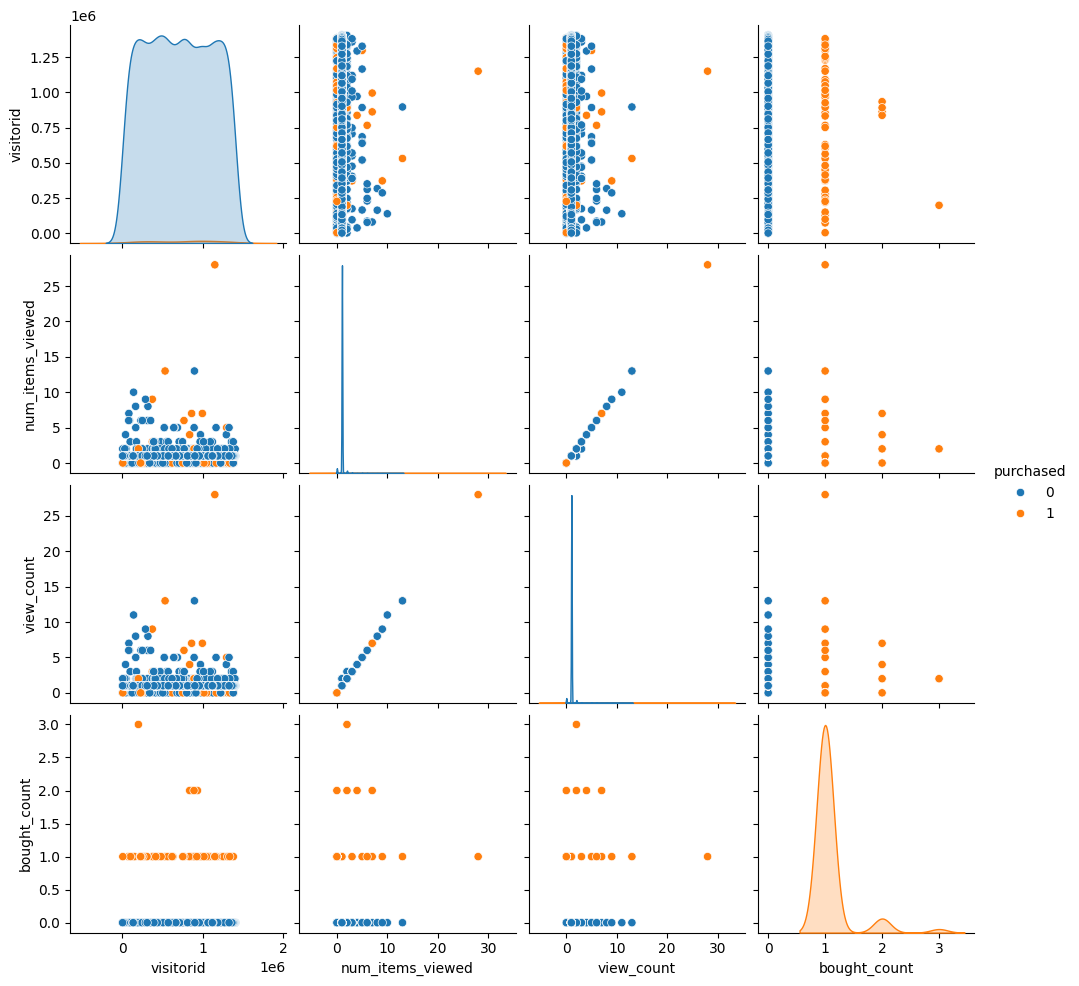

In [69]:
sns.pairplot(data, hue='purchased');

In [70]:
X = data.drop(['purchased', 'visitorid', 'bought_count'], axis=1)
y = data['purchased']

In [71]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 42, train_size = 0.7)

In [73]:
# Создание объект DMatrix для обучающих данных
dtrain = xgb.DMatrix(X_train, label=y_train)

params = {
    'objective':    'binary:logistic',  # для задачи бинарной классификации
    'max_depth':    5,                  # глубина деревьев
    'eta':          0.1,                # скорость обучения
    'eval_metric':  'logloss'           # метрика для оценки качества
}

# Обучение модели
xgb_model = xgb.train(params, dtrain, num_boost_round=100)

# Сделаем прогнозы на тестовых данных
dtest  = xgb.DMatrix(X_test)
y_pred = xgb_model.predict(dtest)

In [74]:
# Сохраним модель на диск
with open(MODEL_PATH + 'xgb_model.pkl', 'wb') as model_file:
    pickle.dump(xgb_model, model_file)

In [75]:
# Оценим качество модели
y_pred_binary = [1 if pred > 0.5 else 0 for pred in y_pred]
accuracy      = accuracy_score(y_test, y_pred_binary)

print("Accuracy:", accuracy.round(3))
print(classification_report(y_test, y_pred_binary))

Accuracy: 0.991
              precision    recall  f1-score   support

           0       0.99      1.00      1.00      1992
           1       0.00      0.00      0.00        18

    accuracy                           0.99      2010
   macro avg       0.50      0.50      0.50      2010
weighted avg       0.98      0.99      0.99      2010



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
